In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler

# EDA

1. Data Cleaning and Preparation

In [185]:
df = pd.read_csv("Cardiotocographic.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Tendency,NSP
0,120.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,0.999926,2.0
1,132.000000,0.006380,0.0,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,10.4,130.0,0.000000,1.0
2,133.000000,0.003322,0.0,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,13.4,130.0,0.000000,1.0
3,134.000000,0.002561,0.0,0.007742,0.002561,0.0,0.0,16.0,2.4,0.0,23.0,117.0,1.000000,1.0
4,131.948232,0.006515,0.0,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,1.000000,1.0


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2105 non-null   float64
 1   AC        2106 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2105 non-null   float64
 6   DP        2105 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2105 non-null   float64
 11  Width     2105 non-null   float64
 12  Tendency  2105 non-null   float64
 13  NSP       2105 non-null   float64
dtypes: float64(14)
memory usage: 232.7 KB


In [187]:
print(df.shape)
print(df.isnull().sum())
print(df.isnull().sum().sum()/len(df)*100)

(2126, 14)
LB          21
AC          20
FM           0
UC           0
DL           0
DS          21
DP          21
ASTV         0
MSTV         0
ALTV         0
MLTV        21
Width       21
Tendency    21
NSP         21
dtype: int64
7.855126999059266


In [188]:
# 1. Removing null rows
print(df.shape) #(2126, 14)

# Since we have more number of rows, which may not affect the analysis, we can comfortably drop 21 rows from 2126 rows
df.dropna(inplace=True)
print(df.shape) #(2105, 14)

(2126, 14)
(2105, 14)


In [189]:
# 2. Removing duplicate values
print(df.duplicated().sum()) #2

# Since we only have 2 dulicate rows in 2105 rows, we can just delete them
df.drop_duplicates(inplace=True, ignore_index=True)
print(df.duplicated().sum()) #0
print(df.shape) #(2103, 14)

2
0
(2103, 14)


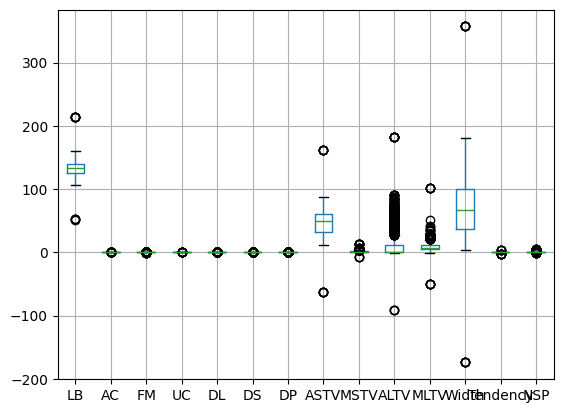

In [190]:
# 3. Detecting and Replacing the Outliers
df.boxplot()
plt.show()

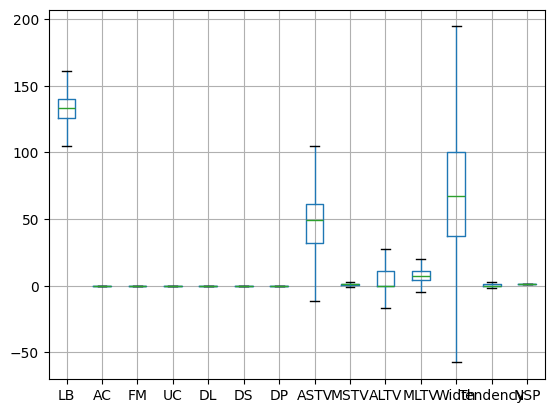

In [191]:
def replace_outliers(df):
    def replace(col):
        Q1 = df[col].quantile(0.25)        
        Q3 = df[col].quantile(0.75)     
        IQR = Q3 - Q1
        lower_extreme = Q1 - 1.5*IQR   
        upper_extreme = Q3 + 1.5*IQR   
        df[col] = df[col].apply(lambda x: lower_extreme if x < lower_extreme else upper_extreme if x > upper_extreme else x)

    for c in df.select_dtypes(include=["int", "float"]).columns:
        replace(c)

replace_outliers(df)
df.boxplot()
plt.show()

2. Pattern Recognition and Insights:

                LB        AC        FM        UC        DL  DS  DP      ASTV  \
LB        1.000000 -0.081715 -0.006829 -0.163801 -0.156858 NaN NaN  0.286501   
AC       -0.081715  1.000000  0.077516  0.092527 -0.103891 NaN NaN -0.272948   
FM       -0.006829  0.077516  1.000000 -0.317088 -0.019641 NaN NaN  0.156314   
UC       -0.163801  0.092527 -0.317088  1.000000  0.270433 NaN NaN -0.217603   
DL       -0.156858 -0.103891 -0.019641  0.270433  1.000000 NaN NaN -0.113746   
DS             NaN       NaN       NaN       NaN       NaN NaN NaN       NaN   
DP             NaN       NaN       NaN       NaN       NaN NaN NaN       NaN   
ASTV      0.286501 -0.272948  0.156314 -0.217603 -0.113746 NaN NaN  1.000000   
MSTV     -0.297040  0.216529  0.069706  0.299700  0.566593 NaN NaN -0.434974   
ALTV      0.323777 -0.410734 -0.013130 -0.295354 -0.295959 NaN NaN  0.438939   
MLTV     -0.041651 -0.151983 -0.036495 -0.072767 -0.242170 NaN NaN -0.324869   
Width    -0.140008  0.284221  0.165149  

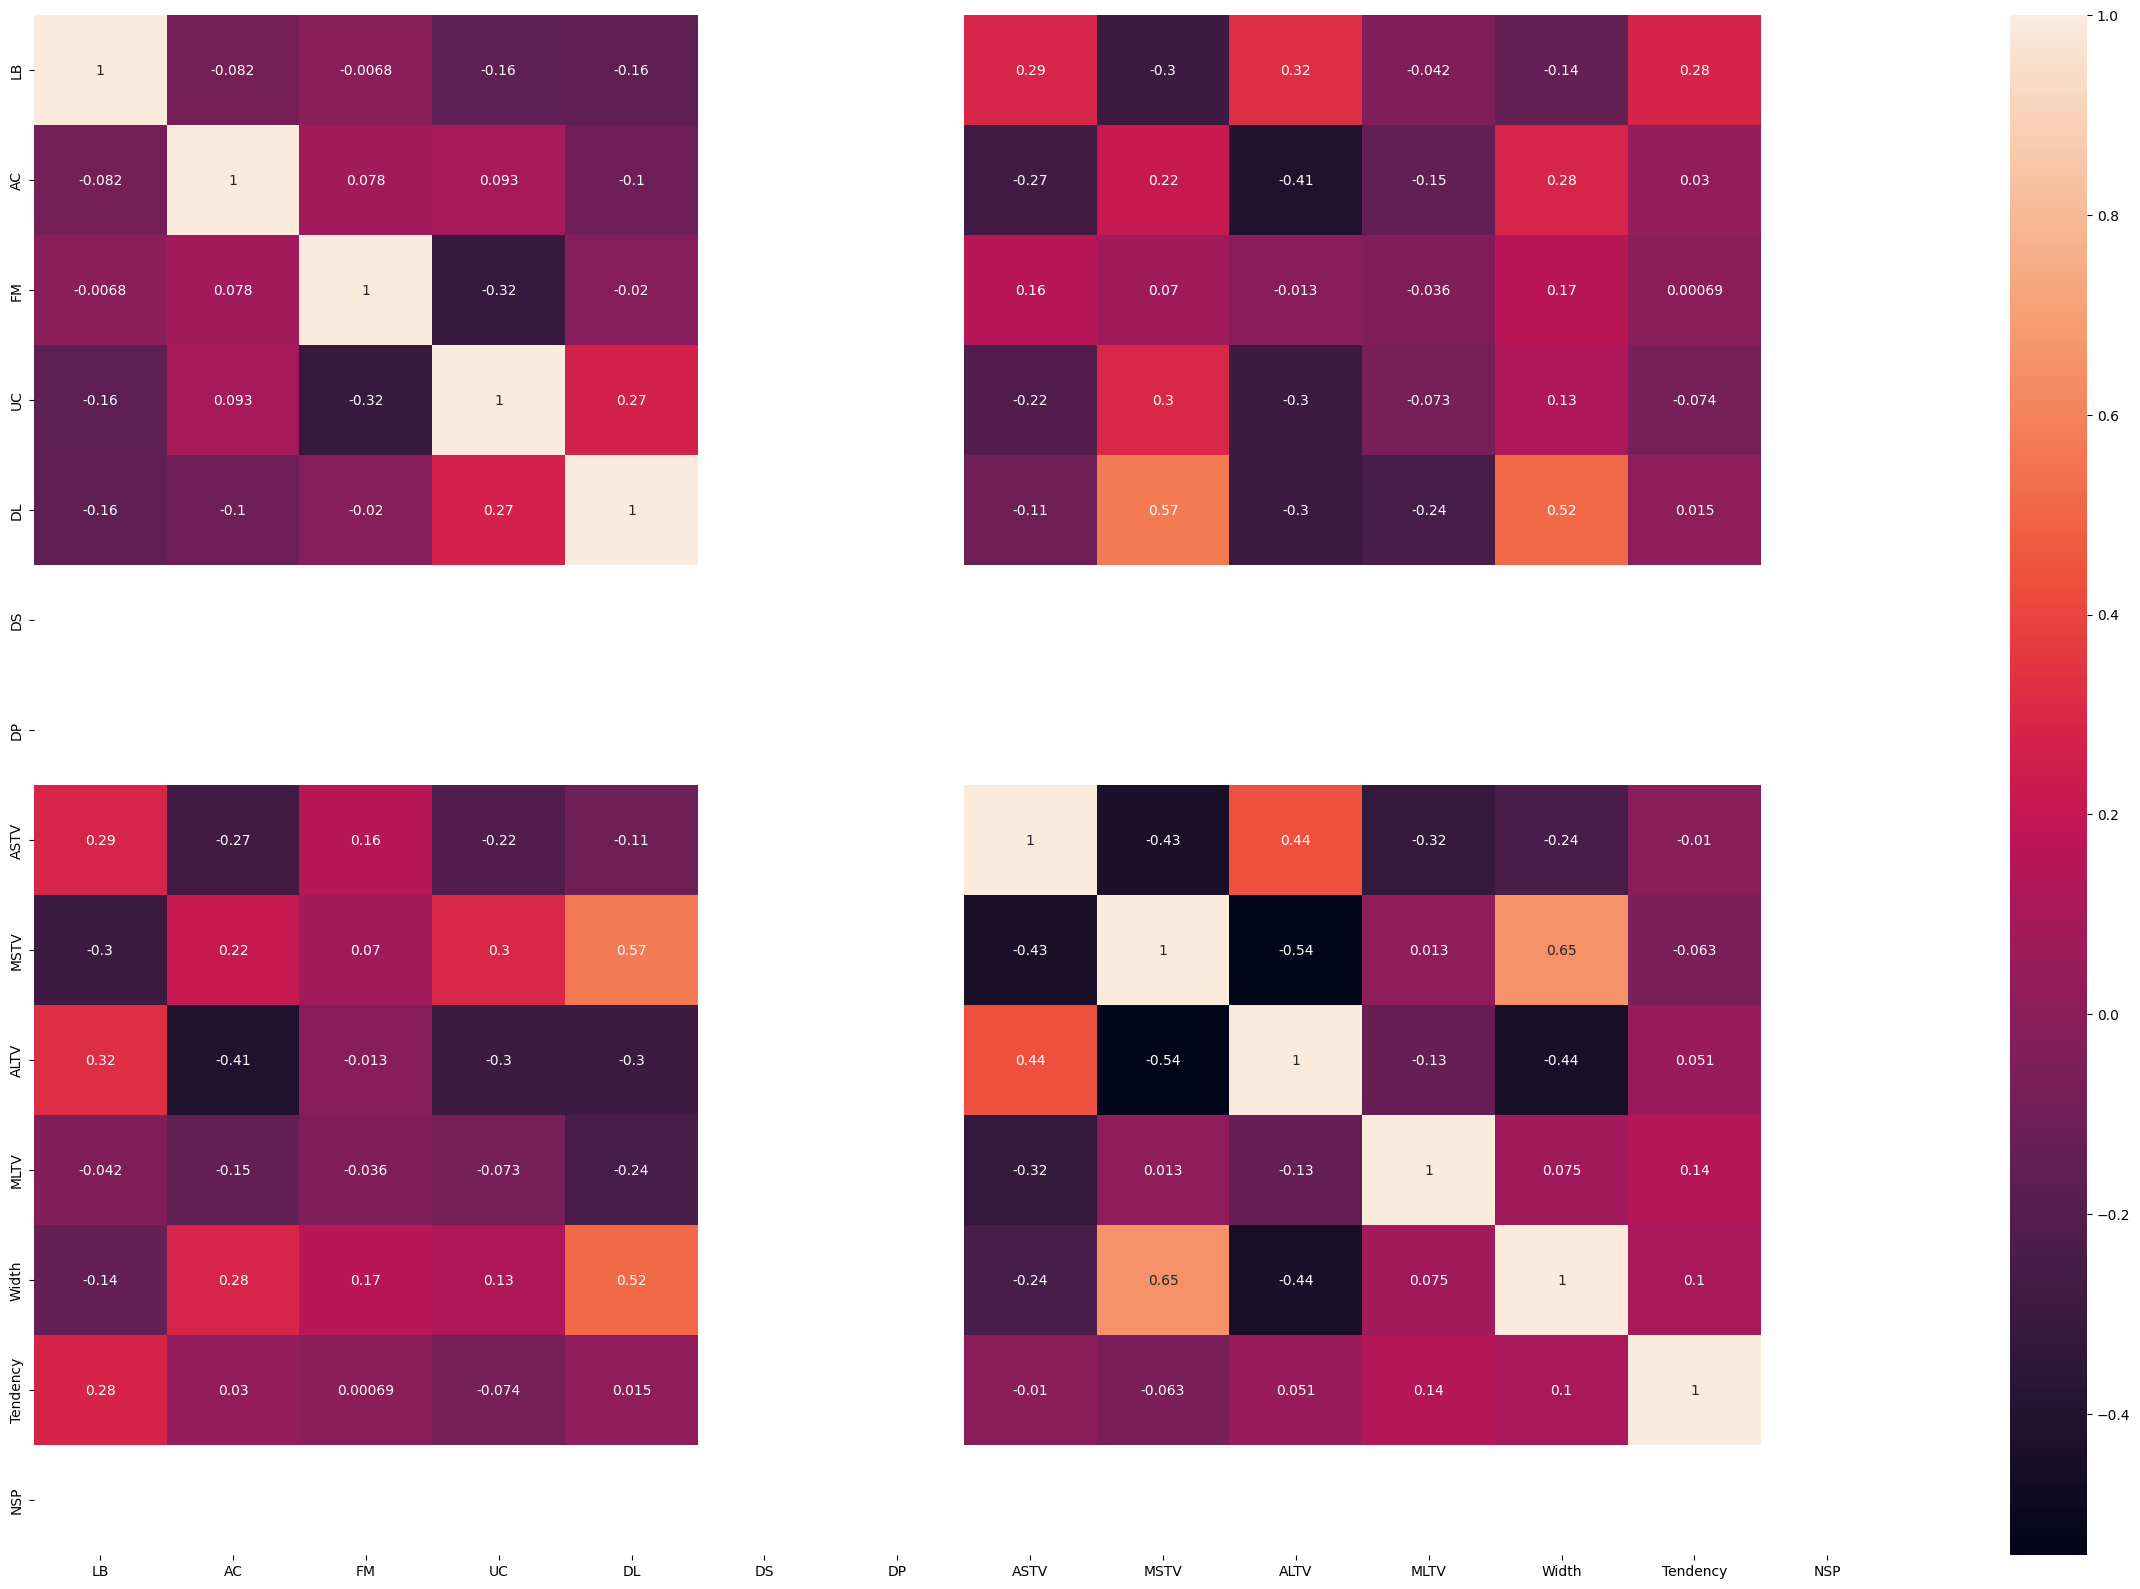

In [192]:
corr = df.corr()
print(corr)
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True)
plt.show()

In [193]:
'''
Columns having multicolinearity of more than 0.5

["ALTV", "MSTV"]
["MSTV", "DL"]
["Width", "DL"]
["Width", "MSTV"]
'''

'\nColumns having multicolinearity of more than 0.5\n\n["ALTV", "MSTV"]\n["MSTV", "DL"]\n["Width", "DL"]\n["Width", "MSTV"]\n'

In [194]:


'''
Improvising for Missing Target Columns

We will add a column called Width Tier where we will rank the width off two categories for the range 357.0
and -174.0, where the values that are less than mean of lower_limit and upper_limit are Tier 0 and the values more than mean are Tier 1 
'''

lower_limit = df["Width"].min()
upper_limit = df["Width"].max()
mean = (lower_limit + upper_limit)/2

width_handler = lambda x : 0 if x <= mean else 1
df["Width Tier"] = [width_handler(value) for value in df["Width"]]
print(df["Width Tier"].unique())

[0 1]


In [195]:
target = df["Width Tier"]
features = df.drop(columns=["Width Tier"])

In [196]:
# 1. Finding multi-collinearity with VIF
vif = pd.DataFrame()
vif["Features"] = features.columns
vif["VIF_SCORES"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif.sort_values(ascending=False, by="VIF_SCORES")

c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Features,VIF_SCORES
13,NSP,250.112011
8,MSTV,2.686258
4,DL,2.341795
11,Width,2.325965
9,ALTV,1.926730
1,AC,1.807517
7,ASTV,1.729009
10,MLTV,1.662201
3,UC,1.336453
0,LB,1.280894


In [197]:
'''
VIF scores shows NSP has multi-collinearity of more than 10, since we have many other rows to work with, we can drop the column "NSP", unless "NSP" has a great correlation with the target columns "Width Tier"
'''

# dropping NSP
features.drop(columns=["NSP"], inplace=True)

c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [5 6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[  39.61160873   88.93072745   60.95487613   17.46435202  812.2493163
           nan           nan   59.67460059  867.28722909  283.541748
    6.88453627 5606.57286818   85.90592807]


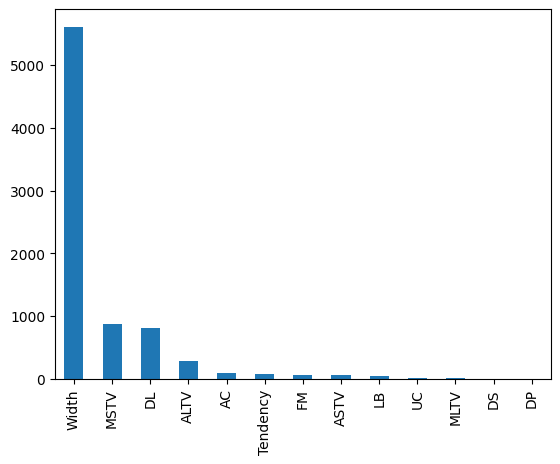

'\nSince the columns ["AC", "DL", "ASTV", "FM", "DP", "DS"] all have a very low correlation to the column "Tendency", and we again have more columns left to work with, we can drop these columns.\n'

In [198]:
'''
2. Finding correlation of features with the target
'''

f_reg= f_classif(features,target)
print(f_reg[0])
pd.Series(f_reg[0],index=features.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()
'''
f_reg[0]: [  39.61160873   17.46435202  867.28722909  283.541748      6.88453627
 5606.57286818   85.90592807] 
'''

'''
Since the columns ["AC", "DL", "ASTV", "FM", "DP", "DS"] all have a very low correlation to the column "Tendency", and we again have more columns left to work with, we can drop these columns.
'''

In [199]:
features.drop(columns=["AC", "DL", "ASTV", "FM", "DP", "DS"], inplace=True)

   Features  Correlation
5     Width  5606.572868
2      MSTV   867.287229
3      ALTV   283.541748
6  Tendency    85.905928
0        LB    39.611609
1        UC    17.464352
4      MLTV     6.884536


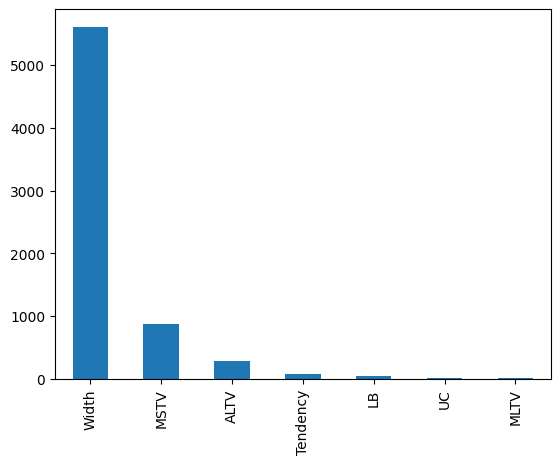

In [200]:
corrdf = pd.DataFrame()
corrdf["Features"] = features.columns
corrdf["Correlation"] = f_classif(features,target)[0]
print(corrdf.sort_values(ascending=False, by="Correlation"))

f_reg= f_regression(features,target)
pd.Series(f_reg[0],index=features.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()

In [201]:
features.head()

,LB,UC,MSTV,ALTV,MLTV,Width,Tendency
0,120.000000,0.000000,0.5,27.5,2.40,64.0,0.999926
1,132.000000,0.006380,2.1,0.0,10.40,130.0,0.000000
2,133.000000,0.008306,2.1,0.0,13.40,130.0,0.000000
3,134.000000,0.007742,2.4,0.0,20.35,117.0,1.000000
4,131.948232,0.008143,2.4,0.0,19.90,117.0,1.000000


3. Data Visualization

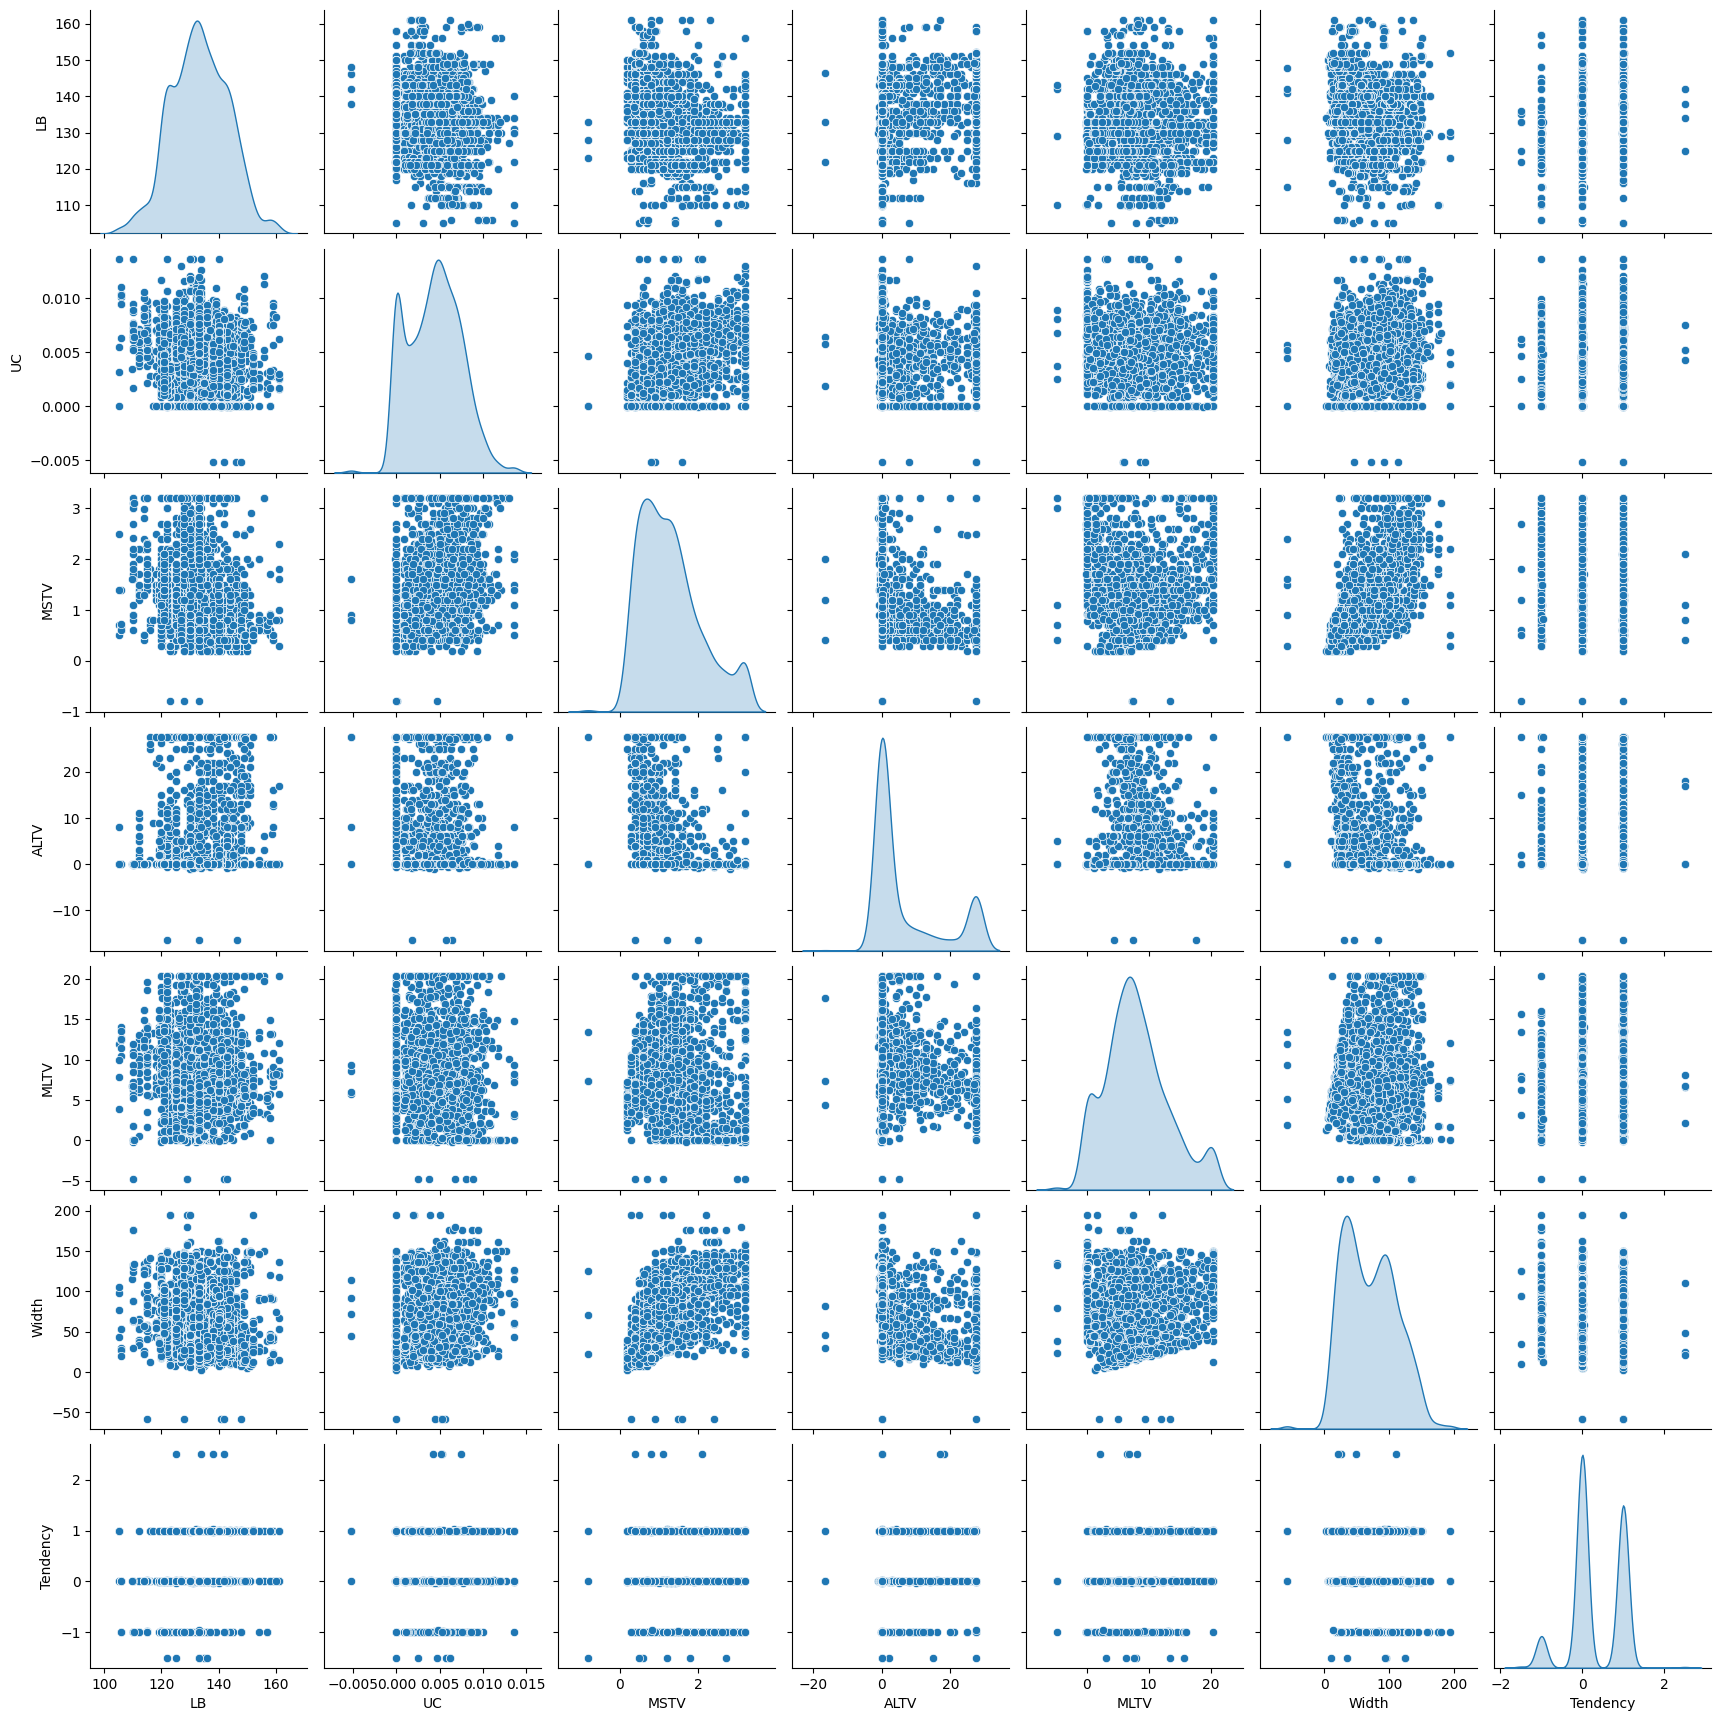

In [202]:
# 1. Pairplot
sns.pairplot(features, diag_kind="kde")
plt.show()


# None of any two columns seem to have an explicity visible positive/ negative correlation. As we also saw earlier, every column except the NSP had a VIF score of less than 3

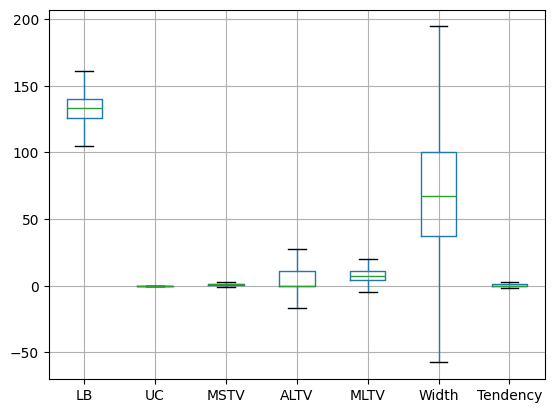

In [203]:
# 2. Boxlot
features.boxplot()
plt.show()

# Since we had already removed the outliers from the columns, we dont have any outliers.

Width Tier
1    1035
0    1068
Name: Width Tier, dtype: int64


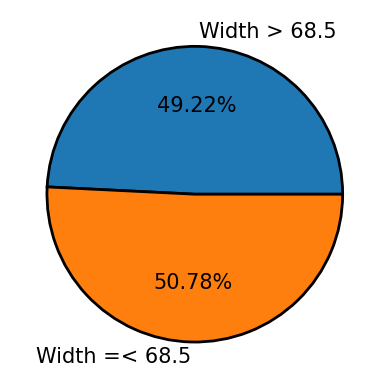

In [204]:
# 3. Pie Chart for Categorical column 
widths = df.groupby("Width Tier")["Width Tier"].count().sort_values()
print(widths)
plt.pie(widths, labels=[f"Width > {mean}", f"Width =< {mean}"], radius=1, autopct="%.2f%%", 
textprops={
    "color":"black",
    "size":15
},
wedgeprops={
    "linewidth":2,
    "edgecolor":"black"
}
)
plt.show()

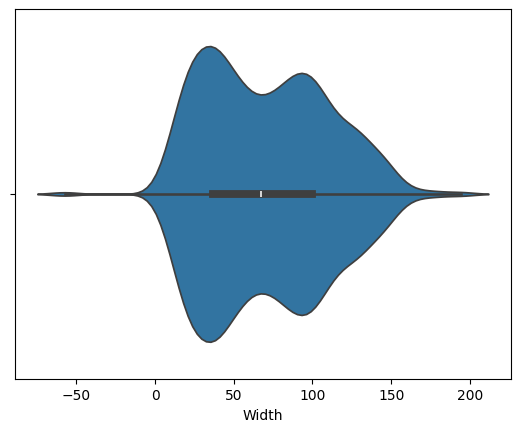

'The data for width shows that there are more number of rows with 0 < width < 75, and the width is slightly skewed to the right, where there is also decent number of rows with 75 < width < 125.'

In [205]:
# 4. Violin Plots
sns.violinplot(data=df, x="Width")
plt.show()

'''The data for width shows that there are more number of rows with 0 < width < 75, and the width is slightly skewed to the right, where there is also decent number of rows with 75 < width < 125.'''

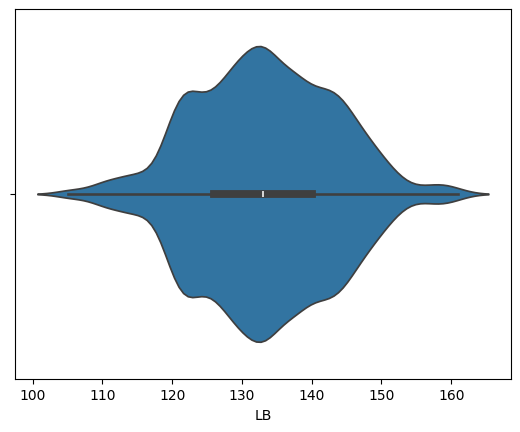

'\nThe LB  values are mostly concentrated around 130 bpm, with moderate spread and few extremes, indicating a fairly stable central tendency with mild variability.\n'

In [206]:
# 'LB', 'UC', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Tendency'
sns.violinplot(data=df, x='LB')
plt.show()

'''
The LB  values are mostly concentrated around 130 bpm, with moderate spread and few extremes, indicating a fairly stable central tendency with mild variability.
'''

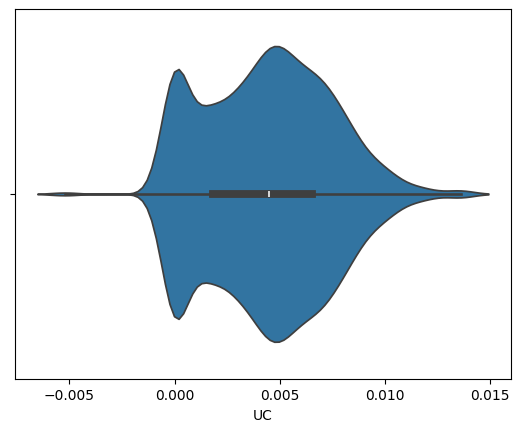

' \nUC values are heavily concentrated near zero with a slight right skew, indicating most recordings have very low UC activity and only a few higher intensity cases.\n'

In [207]:
sns.violinplot(data=df, x='UC')
plt.show()

''' 
UC values are heavily concentrated near zero with a slight right skew, indicating most recordings have very low UC activity and only a few higher intensity cases.
'''

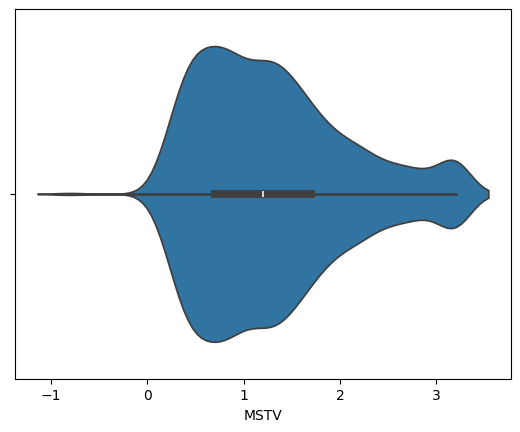

'\nMSTV values cluster around low to moderate levels with a right skewed distribution, suggesting most cases have moderate short term variability while a few show higher variability.\n'

In [208]:
sns.violinplot(data=df, x='MSTV')
plt.show()

'''
MSTV values cluster around low to moderate levels with a right skewed distribution, suggesting most cases have moderate short term variability while a few show higher variability.
'''

5. Summary

In [209]:
'''
 - The Width Tier is somewhat positively correlated to MSTV column, making it the column that is most related to the width.
 - The Logistic Regression model can be made more precise by utilizing the MSTV column. With more rows we can have an optimized prediction of Width.
 - The rows with width less than the mean are only slightly more than the rows with width more than the mean, that implies the width is distributed evenly to an extent, predicting a range for it would be a challenge.

 - Without removing all the ouliers that lie within the data, the Width Tier data is intensely skewed towards "Tier 0", 
    Width Tier
    1     681
    0    1422
    With some suggesstion of the seniors we can decide to include some rows with outliers, so that the results are more towards one value.
'''

'\n - The Width Tier is somewhat positively correlated to MSTV column, making it the column that is most related to the width.\n - The Logistic Regression model can be made more precise by utilizing the MSTV column. With more rows we can have an optimized prediction of Width.\n - The rows with width less than the mean are only slightly more than the rows with width more than the mean, that implies the width is distributed evenly to an extent, predicting a range for it would be a challenge.\n\n - Without removing all the ouliers that lie within the data, the Width Tier data is intensely skewed towards "Tier 0", \n    Width Tier\n    1     681\n    0    1422\n    With some suggesstion of the seniors we can decide to include some rows with outliers, so that the results are more towards one value.\n'